# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [28]:
# load in the data, specifying datatypes for columns 18 and 19, which have mixtures of datatypes, to speed up import
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18: object, 19: object})
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18: object, 19: object})

# Create backup copies to avoid having to reimport
azdias_copy = azdias.copy()
customers_copy = customers.copy()

In [3]:
# Overview of customer data
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [4]:
# Overview of azdias data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


### Sort data types

In [5]:
# Find names of problematic 18th and 19th columns
customers.columns[18], customers.columns[19]
# According to the schema, these columns are the New German CAMEO Typology established together with Call Credit in late 2015

('CAMEO_DEUG_2015', 'CAMEO_INTL_2015')

In [6]:
# Also according to the schema, there should be an additional associated column named. Finding this to investigate this column too
cameo_cols = [col for col in customers.columns if 'CAMEO' in col]
print(cameo_cols)
# 3rd Cameo column is CAMEO_DEU_2015

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']


In [7]:
# First problematic column contains numbers and NaN values
customers['CAMEO_DEUG_2015'].head()

0      1
1    NaN
2      5
3      4
4      7
Name: CAMEO_DEUG_2015, dtype: object

In [8]:
# Second problematic column contains numbers and NaN values
customers['CAMEO_INTL_2015'].head()

0     13
1    NaN
2     34
3     24
4     41
Name: CAMEO_INTL_2015, dtype: object

In [9]:
# The associated 3rd columm is a mixture of number-letter combos and NaN values
customers['CAMEO_DEU_2015'].head()

0     1A
1    NaN
2     5D
3     4C
4     7B
Name: CAMEO_DEU_2015, dtype: object

In [10]:
# Change columns 18 and 19 to type float
customers['CAMEO_DEUG_2015'] = pd.to_numeric(customers['CAMEO_DEUG_2015'], errors='coerce')
customers['CAMEO_INTL_2015'] = pd.to_numeric(customers['CAMEO_INTL_2015'], errors='coerce')
azdias['CAMEO_DEUG_2015'] = pd.to_numeric(azdias['CAMEO_DEUG_2015'], errors='coerce')
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias['CAMEO_INTL_2015'], errors='coerce')

In [11]:
# Find other columns with type object
cust_object_columns = customers.columns[customers.dtypes == object]
az_object_columns = azdias.columns[azdias.dtypes == object]
customers[cust_object_columns].head()
# Column EINGEFUEGT_AM should be dtype datetime, columns PRODUCT_GROUP, CUSTOMER_GROUP and OST_WEST_KZ are categorical

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


In [14]:
# Change EINGEFUEGT_AM to type datetime in both datasets
customers['EINGEFUEGT_AM'] =  pd.to_datetime(customers['EINGEFUEGT_AM'], format='%Y-%m-%d %H:%M:%S')
azdias['EINGEFUEGT_AM'] =  pd.to_datetime(azdias['EINGEFUEGT_AM'], format='%Y-%m-%d %H:%M:%S')

### Clean data and sort categorical data

In [16]:
# Find number of columns completely missing data and exclude if present
customers_missing_columns = len(customers.columns[customers.isnull().sum(axis = 0)/customers.shape[0]*100 == 100])
azdias_missing_columns = len(azdias.columns[azdias.isnull().sum(axis = 0)/azdias.shape[0]*100 == 100])
print ("There are {} and {} columns missing all values in the customers and azdias datasets respectively".format(customers_missing_columns, azdias_missing_columns))

There are 0 and 0 columns missing all values in the customers and azdias datasets respectively


In [17]:
# Find number of rows completely missing data and exclude if present
customers_missing_data = len(customers[customers.isnull().sum(axis = 1)/customers.shape[1]*100 == 100])
azdias_missing_data = len(azdias[azdias.isnull().sum(axis = 1)/azdias.shape[1]*100 == 100])
print ("There are {} and {} rows missing all values in the customers and azdias datasets respectively".format(customers_missing_data, azdias_missing_data))

There are 0 and 0 rows missing all values in the customers and azdias datasets respectively


Text(0.5,0,'columns in dataset')

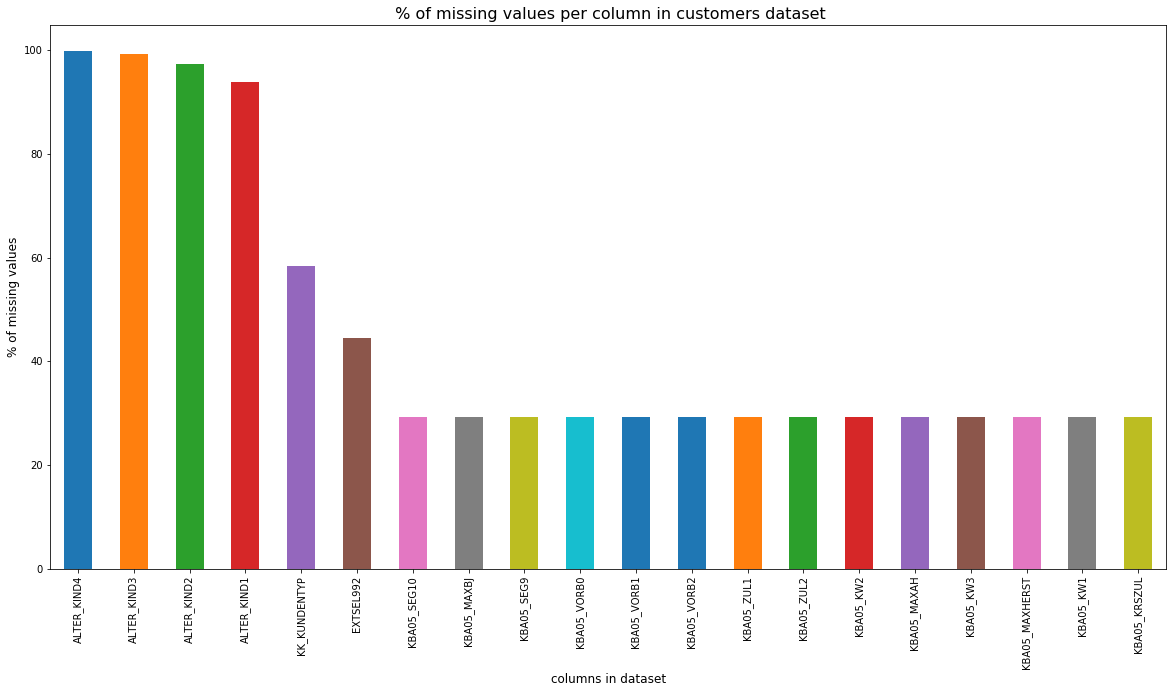

In [18]:
# Find columns with most missing data in customers dataset
round(customers.isnull().sum(axis = 0)/customers.shape[0]*100,2).sort_values(ascending = False).head(20).plot(kind = 'bar', figsize=(20,10))
plt.title(" % of missing values per column in customers dataset", fontdict={'fontsize': 16})
plt.ylabel('% of missing values', fontdict={'fontsize': 12})
plt.xlabel('columns in dataset', fontdict={'fontsize': 12})

Text(0.5,0,'columns in dataset')

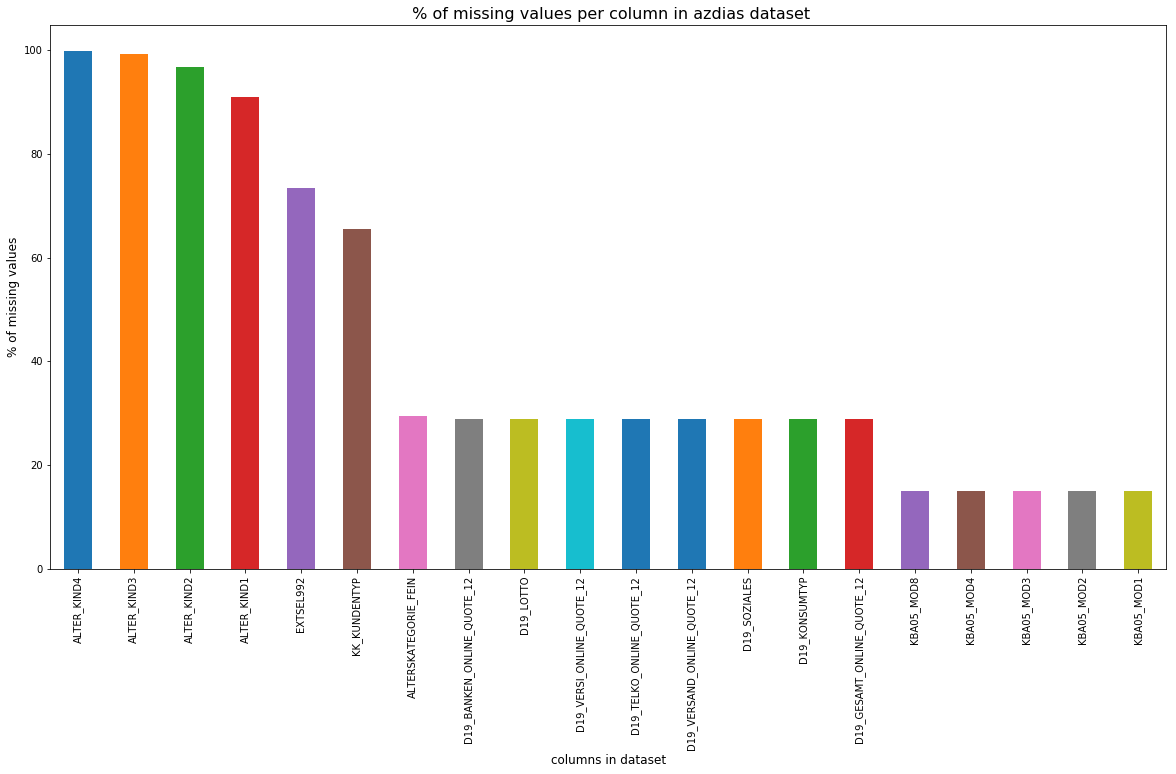

In [19]:
# Find columns with most missing data in azdias dataset
round(azdias.isnull().sum(axis = 0)/azdias.shape[0]*100,2).sort_values(ascending = False).head(20).plot(kind = 'bar', figsize=(20,10))
plt.title(" % of missing values per column in azdias dataset", fontdict={'fontsize': 16})
plt.ylabel('% of missing values', fontdict={'fontsize': 12})
plt.xlabel('columns in dataset', fontdict={'fontsize': 12})

In [20]:
# The columns which the most empty values in both datasets are ALTER_KIND1-4, EXTSEL992 and KK_KUNDENTYPE
# Remove these columns as they hold little information
cols_to_remove = ['ALTER_KIND1', 'ALTER_KIND2','ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
customers_clean = customers.drop(columns = cols_to_remove, axis=1)
azdias_clean = azdias.drop(columns = cols_to_remove, axis=1)

In [13]:
# Fill categorical variables with mode
# Create function which fills missing values with mode
fill_mode = lambda col: col.fillna(col.mode()[0])

# Fill missing categorical variables with mode
customers[cust_object_columns] = customers[cust_object_columns].apply(fill_mode, axis=0)
azdias[az_object_columns] = azdias[az_object_columns].apply(fill_mode, axis=0)

In [15]:
customers = pd.get_dummies(data=customers, columns=['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'OST_WEST_KZ'])
azdias = pd.get_dummies(data=azdias, columns=['OST_WEST_KZ'])

In [22]:
# Create function which fills missing values in columns within num_vars with the column mean
def fill_mean(df, num_vars):
    '''
    INPUT:
    df - dataframe with missing numeric values
    num_vars - object containing numeric columns in dataframe
    OUTPUT:
    df - dataframe with missing numeric values filled with column means
    
    Fills missing numeric values within a dataframe with column means.
    '''
    for col in num_vars:
            df[col] = df[col].fillna(df[col].mean(), axis = 0)
    return df

In [23]:
# Fill missing numerical values
# Find numerical columns
customers_num_vars = customers_clean.select_dtypes(include=['float', 'int']).columns
azdias_num_vars = azdias_clean.select_dtypes(include=['float', 'int']).columns

# Fill missing values in numerical columns
filled_customers = fill_mean(customers_clean, customers_num_vars)
filled_azdias = fill_mean(azdias_clean, azdias_num_vars)
filled_customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,CUSTOMER_GROUP_MULTI_BUYER,CUSTOMER_GROUP_SINGLE_BUYER,OST_WEST_KZ_O,OST_WEST_KZ_W
0,9626,2,1.0,10.0,10.000000,1.000000,0.000000,0.0,2.0,1.000000,...,0,1,4,0,1,0,1,0,0,1
1,9628,-1,9.0,11.0,10.331579,4.965863,0.067413,0.0,3.0,4.701288,...,0,1,4,0,0,1,0,1,0,1
2,143872,-1,1.0,6.0,0.000000,1.000000,0.000000,0.0,1.0,1.000000,...,0,2,4,0,1,0,1,0,0,1
3,143873,1,1.0,8.0,8.000000,0.000000,0.067413,0.0,0.0,1.000000,...,0,1,4,1,0,0,1,0,0,1
4,143874,-1,1.0,20.0,14.000000,7.000000,0.000000,0.0,4.0,7.000000,...,0,1,3,0,0,1,1,0,0,1


In [24]:
filled_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 367 entries, LNR to OST_WEST_KZ_W
dtypes: datetime64[ns](1), float64(263), int64(94), object(2), uint8(7)
memory usage: 527.7+ MB


In [25]:
round(filled_azdias.isnull().sum(axis = 0)/filled_azdias.shape[0]*100,2).sort_values(ascending = False).head(10)

OST_WEST_KZ_W         0.0
HH_EINKOMMEN_SCORE    0.0
KBA05_ALTER1          0.0
KBA05_ALTER2          0.0
KBA05_ALTER3          0.0
KBA05_ALTER4          0.0
KBA05_ANHANG          0.0
KBA05_ANTG1           0.0
KBA05_ANTG2           0.0
KBA05_ANTG3           0.0
dtype: float64

In [26]:
round(filled_customers.isnull().sum(axis = 0)/filled_customers.shape[0]*100,2).sort_values(ascending = False).head(10)

OST_WEST_KZ_W     0.0
KBA05_ALTER1      0.0
KBA05_ALTER3      0.0
KBA05_ALTER4      0.0
KBA05_ANHANG      0.0
KBA05_ANTG1       0.0
KBA05_ANTG2       0.0
KBA05_ANTG3       0.0
KBA05_ANTG4       0.0
KBA05_AUTOQUOT    0.0
dtype: float64

In [32]:
# Create function to clean datasets
def clean_data(df):
    '''
    INPUT:
    df - dataframe of customer data
    OUTPUT:
    df_clean - clean dataframe of customer data, ready for modelling
    
    Sorts columns with incorrect datatypes
    Removes columns with high proportion of missing data
    Impute missing data
    Transforms categorical data so it can be used in modelling
    '''
    # Sort columns with incorrect datatypes
    df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'], errors='coerce')
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'], errors='coerce')
    df['EINGEFUEGT_AM'] =  pd.to_datetime(df['EINGEFUEGT_AM'], format='%Y-%m-%d %H:%M:%S')
    
    # Remove columns with high proportion of missing data
    cols_to_remove = ['ALTER_KIND1', 'ALTER_KIND2','ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
    df = df.drop(columns = cols_to_remove, axis=1)
    
    # Impute missing data in categorical columns
    df_object_columns = df.columns[df.dtypes == object]
    df[cust_object_columns] = df[cust_object_columns].apply(fill_mode, axis=0)
    
    # Transform categorical data so it can be used in modelling
    df = pd.get_dummies(data=df, columns=['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'OST_WEST_KZ'])
    
    # Impute missing data in numeric columns
    df_num_vars = df.select_dtypes(include=['float', 'int']).columns
    df_clean = fill_mean(df, customers_num_vars)
    
    return df_clean

In [33]:
clean_customers = clean_data(customers)

In [29]:
# Check function is working
round(customers.isnull().sum(axis = 0)/customers.shape[0]*100,2).sort_values(ascending = False).head(10)

ALTER_KIND4     99.88
ALTER_KIND3     99.33
ALTER_KIND2     97.34
ALTER_KIND1     93.86
KK_KUNDENTYP    58.41
EXTSEL992       44.50
KBA05_SEG7      29.21
KBA05_KW1       29.21
KBA05_SEG4      29.21
KBA05_SEG5      29.21
dtype: float64

In [34]:
round(clean_customers.isnull().sum(axis = 0)/clean_customers.shape[0]*100,2).sort_values(ascending = False).head(10)
# There are no longer any missing values in the dataset suggesting the function is working

OST_WEST_KZ_W     0.0
KBA05_ALTER1      0.0
KBA05_ALTER3      0.0
KBA05_ALTER4      0.0
KBA05_ANHANG      0.0
KBA05_ANTG1       0.0
KBA05_ANTG2       0.0
KBA05_ANTG3       0.0
KBA05_ANTG4       0.0
KBA05_AUTOQUOT    0.0
dtype: float64

In [30]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [35]:
clean_customers.head()
# Categorical variables have been transformed so the function appears to be working

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,CUSTOMER_GROUP_MULTI_BUYER,CUSTOMER_GROUP_SINGLE_BUYER,OST_WEST_KZ_O,OST_WEST_KZ_W
0,9626,2,1.0,10.0,10.000000,1.000000,0.000000,0.0,2.0,1.000000,...,0,1,4,0,1,0,1,0,0,1
1,9628,-1,9.0,11.0,10.331579,4.965863,0.067413,0.0,3.0,4.701288,...,0,1,4,0,0,1,0,1,0,1
2,143872,-1,1.0,6.0,0.000000,1.000000,0.000000,0.0,1.0,1.000000,...,0,2,4,0,1,0,1,0,0,1
3,143873,1,1.0,8.0,8.000000,0.000000,0.067413,0.0,0.0,1.000000,...,0,1,4,1,0,0,1,0,0,1
4,143874,-1,1.0,20.0,14.000000,7.000000,0.000000,0.0,4.0,7.000000,...,0,1,3,0,0,1,1,0,0,1


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')